# 2023-01-19 ‚Ä¢ Fit a line

We're working off `2022-10-24 ‚Ä¢ N-to-1 with lognormal inputs`.

But trying a new detection method.

(Linear regression of voltage against time-post-spike)

Note that, unlike in earlier sims, there is no transmission delay added in the latest sim.

## Setup

I'll put the work from previous notebook in a script (not package, this time)

(Thanks to 'jupytext' extension, that script'll also be a notebook)

In [2]:
include("2023-01-19__[input].jl");

using Revise: 2.418806 seconds (603.38 k allocations: 36.618 MiB, 4.00% gc time, 1.02% compilation time)
using MyToolbox: 5.079011 seconds (1.63 M allocations: 103.773 MiB, 2.95% gc time, 0.44% compilation time)
using SpikeWorks: 2.238519 seconds (1.28 M allocations: 78.599 MiB, 5.98% gc time)
using Sciplotlib: 26.325986 seconds (7.10 M allocations: 455.083 MiB, 1.64% gc time, 2.21% compilation time: 100% of which was recompilation)
using VoltoMapSim: 14.394408 seconds (4.98 M allocations: 328.898 MiB, 3.82% gc time)
Loading cached output from `/root/.phdcache/runsim/2023-01-19__[input]__N=5.jld2` ‚Ä¶ done (17.3 s)
Loading cached output from `/root/.phdcache/runsim/2023-01-19__[input]__N=20.jld2` ‚Ä¶ done (0.3 s)
Loading cached output from `/root/.phdcache/runsim/2023-01-19__[input]__N=100.jld2` ‚Ä¶ done (0.3 s)
Loading cached output from `/root/.phdcache/runsim/2023-01-19__[input]__N=400.jld2` ‚Ä¶ done (0.3 s)
Loading cached output from `/root/.phdcache/runsim/2023-01-19__[input]__N=1

(I disabled STA calculating/caching/loading in there: we're gon work on individual windows).

## Start

We'll tackle the most difficult case.

In [3]:
i = 6

6

In [88]:
N = Ns[i]

6500

In [7]:
sim = sims[i]

Simulation{Nto1System{NeuronModel{NamedTuple{(:v, :u, :g‚Çë, :g·µ¢), NTuple{4, Float64}}, typeof(f!), typeof(has_spiked), typeof(on_self_spike!)}, var"#on_spike_arrival!#9"{Float64, Float64, var"#neuron_type#8"{Int64}}}, CVec{(:v, :u, :g‚Çë, :g·µ¢)}}
Summary: completed. 5.3 spikes/s
Properties: 
       system: Nto1System, x‚ÇÄ: (v = -0.05, u = 0, g‚Çë = 0, g·µ¢ = 0), input feed: all 19426057 spikes processed
           Œît: 0.0001
     duration: 600
  stepcounter: 6000000 (complete)
        state: t = 600 seconds, neuron = vars: (v: -0.0374, u: -2.95E-11, g‚Çë: 3.59E-09, g·µ¢: 2.45E-09), D‚Çúvars: (v: 0.994, u: -4.64E-10, g‚Çë: -5.2E-07, g·µ¢: -3.55E-07)
          rec: v: [-0.0501, -0.0501, -0.0502, -0.0503, -0.0504, -0.0504, -0.0505, -0.0506, -0.0506, -0.0507  ‚Ä¶  -0.0383, -0.0382, -0.0381, -0.038, -0.0379, -0.0378, -0.0377, -0.0376, -0.0375, -0.0374], spiketimes: [0.116, 0.264, 0.504, 0.68, 0.881, 1.08, 1.25, 1.46, 1.66, 1.84  ‚Ä¶  598, 598, 598, 599, 599, 599, 599, 600, 600, 600]


In [6]:
spikerate(sim) / Hz  # ..of the single output neuron

5.29

In [8]:
inp = inps[i];

---

So we could fit an STA. then there's one `y` per `x`; a 100 `x`s (for 10 ms post 'arrival').

Or we could do individual windows. Let's do that.
(How many datapoints then?

50 Hz input for 10minutes:

In [9]:
_numspikes = 50Hz*10minutes

3E+04

So 30_000 windows. And 30_000 `y`'s per `x`. (per `t`, actually)

Let's find highest spiking exc neuron

In [10]:
actual_spike_rates = spikerate_.(inp.inputs);

In [11]:
for f in [minimum, median, mean, maximum]
    println(lpad(f, 8), ": ", f(actual_spike_rates), " Hz")
end

 minimum: 0.338 Hz
  median: 3.96 Hz
    mean: 4.98 Hz
 maximum: 63.5 Hz


In [12]:
N‚Çë = inp.N‚Çë

5200

In [13]:
_, ni = findmax(actual_spike_rates)

(63.5, 3743)

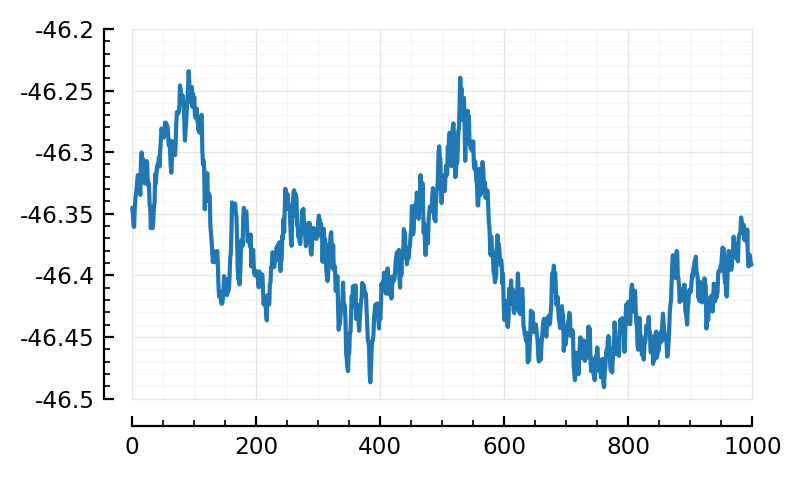

In [14]:
calcSTA(ni) = calcSTA(sim, spiketimes(inp.inputs[ni]))

plot(calcSTA(ni) / mV);

But we're not fitting STAs, we're fitting indiv windows.
So.

(Wow, this one (3743, on WSL) is weird).

## Windows

In [16]:
function windows(v, times, Œît, winsize)
    # Assuming that times occur in [0, T)
    win_starts = floor.(Int, times / Œît) .+ 1
    wins = Vector{Vector{eltype(v)}}()
    for a in win_starts
        b = a + winsize - 1
        if b ‚â§ lastindex(v)
            push!(wins, v[a:b])
        end
    end
    return wins
end

windows(spiketimes) = windows(
    vrec(sim),
    spiketimes,
    Œît,
    winsize,
)

windows(i::Int) = windows(spiketimes(inp.inputs[i]));

In [17]:
# check for type inferrability
# st = spiketimes(inp.inputs[1])
# @code_warntype windows(vrec(sim), st, Œît, winsize)
# ok ‚úî

In [18]:
@time wins = windows(ni);
println()
print(Base.summary(wins))

  1.248030 seconds (97.44 k allocations: 300.789 MiB, 20.77% gc time)

38091-element Vector{Vector{Float64}}

Now to make the data matrix

## Data matrix

We'll fit slope and intercept. So each datapoint, each row of X, is `[1, t]`

In [19]:
function build_Xy(windows, timepoints = 1:100)
    T = eltype(eltype(windows))
    N = length(windows) * length(timepoints)
    X = Matrix{T}(undef, N, 2)
    y = Vector{T}(undef, N)
    i = 1
    for win in windows
        for (t·µ¢, y·µ¢) in zip(timepoints, win[timepoints])
            X[i,:] .= [1, t·µ¢]
            y[i] = y·µ¢
            i += 1
        end
    end
    @assert i == N + 1
    return (X, y)
end


@time X, y = build_Xy(wins);

  2.270752 seconds (4.09 M allocations: 426.801 MiB, 6.93% gc time)


In [20]:
# check for type inferrability
# @code_warntype build_Xy(wins, 1:100)
# ok ‚úî

In [21]:
size(X)

(3809100, 2)

In [22]:
size(y)

(3809100,)

Some example data:

In [23]:
_r = 95:105

[X[_r, :] y[_r] / mV]

11√ó3 Matrix{Float64}:
 1   95  -46.5
 1   96  -46.5
 1   97  -46.5
 1   98  -46.5
 1   99  -46.5
 1  100  -46.5
 1    1  -45.2
 1    2  -45.2
 1    3  -45.2
 1    4  -45.2
 1    5  -45.2

So for our model `y = ax + b`  (w/ `Œ≤ = [b, a]`)

`x` is in units of 'timestep'\
So `a` will be too: mV/timestep

## Solve

Linear regression *assuming Gaussian noise* ‚Üí MSE, 'OLS', normal equations

`?\` ‚Üí "`\(X,y)` for rectangular `X`:\
minimum-norm least squares solution computed by \
a pivoted QR factorization of `X` \
and a rank estimate of `X` based on the R factor"


In [26]:
@time Œ≤ÃÇ = X \ y

  0.311424 seconds (31 allocations: 87.250 MiB)


2-element Vector{Float64}:
 -0.0463
  9.59E-07

(First run time i.e. including compilation: 4 seconds)

In [27]:
intercept = Œ≤ÃÇ[1] / mV

-46.3

Ok check

For the slope,

In [28]:
slope = Œ≤ÃÇ[2] / mV

0.000959

That's per timestep.

Per second:

In [29]:
slope / Œît

9.59

## Plot some windows

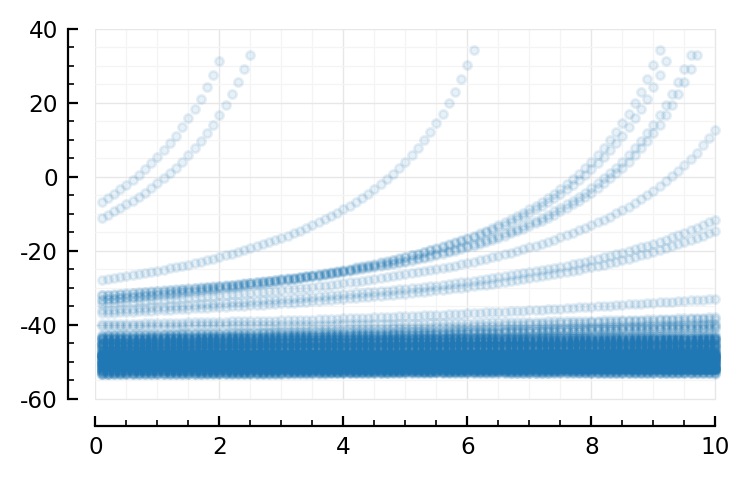

In [30]:
ts = @view X[:,2]
sel = 1:10000

plot(ts[sel]*Œît/ms, y[sel]/mV, ".", alpha=0.1);

It's the spikes we see there.\
(and the unrealistically slow quadratic ramp-ups of Izhikevich)

so let's zoom in

In [31]:
Ny = length(y)

3809100

3M datapoints (one connection, 10 minutes recording)

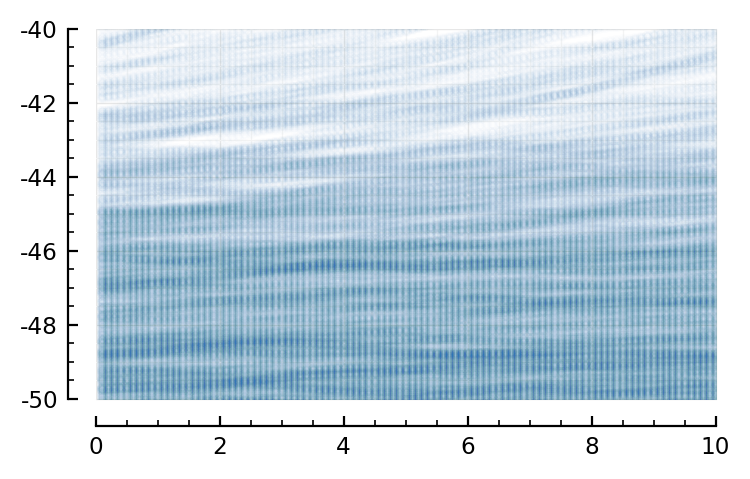

In [32]:
sel = 1:100_000

plot(
    ts[sel]*Œît/ms,
    y[sel]/mV,
    ".";
    alpha = 0.01,
    ylim = [-50, -40],  # mV
    clip_on = true,
);

(Not very informative)

## Use as conntest

(We could look at uncertainty / goodness of fit but not now)

First, let's see what fitted slope is for an inh input; and a shuffled one.

In [33]:
inh_neurons = N‚Çë+1:N

5201:6500

In [34]:
ni·µ¢ = N‚Çë + argmax(actual_spike_rates[inh_neurons])

5798

In [35]:
actual_spike_rates[ni·µ¢] / Hz

43.9

In [36]:
"""
Fit straight line to first 100 ms of
windows cut out of output neuron's voltage signal,
aligned to given times `z`
(or spiketimes of input neuron w/ index `z`).
"""
fitwins(z) = begin
    wins = windows(z)
    X, y = build_Xy(wins)
    Œ≤ÃÇ = vec(X \ y)
    yÃÇ = X * Œ≤ÃÇ
    ŒµÃÇ = y .- yÃÇ
    return (;
        X, y, Œ≤ÃÇ,
        intercept   = Œ≤ÃÇ[1] / mV,       # in mV
        slope       = Œ≤ÃÇ[2] / mV / Œît,  # in mV/second
        predictions = yÃÇ,
        residuals   = ŒµÃÇ,
    )
end;

In [37]:
# check for type inferrability
# @code_warntype fitwins(ni·µ¢)
# ok ‚úî

In [40]:
@time fitwins(ni·µ¢).slope

  1.573785 seconds (2.69 M allocations: 589.847 MiB, 22.97% gc time)


-26

(First run time: 2.7 seconds)

In [41]:
ni‚Çë = ni

3743

In [43]:
@time fitwins(ni‚Çë).slope

  2.091091 seconds (3.89 M allocations: 852.352 MiB, 12.40% gc time)


9.59

In [44]:
spiketimes(i::Int) = spiketimes(inp.inputs[i])

st‚Çë = spiketimes(ni‚Çë)

@time fitwins(shuffle_ISIs(st‚Çë)).slope

  2.472024 seconds (4.60 M allocations: 902.115 MiB, 6.14% gc time)


8.06

Okido

Now, to use as conntest.

Null hypothesis is that slope = 0

Refresher at
https://gregorygundersen.com/blog/2021/09/09/ols-hypothesis-testing/

### Hypothesis testing

If the slope actually were 0\
(i.e. $b_p = b_1 = 0$ in the post),

(and if noise were gaussian, which it's not given the assymetric spiking)

then we expect the slope ("$Œ≤ÃÇ_1$"), to be distributed as:

$$
\hat{Œ≤}_1 \sim \mathcal{N}(0, œÉ¬≤ Q_{[2,2]})
$$
where $Q$ is the inverse of the Gram matrix $X^T X$:

$$
Q = (X'X)^{-1}
$$

($Q$ 'is related to' the covariance matrix, and is called the cofactor matrix.\
https://en.wikipedia.org/wiki/Ordinary_least_squares#Estimation)

..and with $œÉ$ the (unkown) standard-deviation of our
supposedly-Gaussian-distributed noise $Œµ$ in our model

$$
y_i = Œ≤_0 + Œ≤_1 x_i + Œµ_i,
$$
i.e.

$$
Œµ \sim \mathcal{N}(0, œÉ¬≤).
$$

('$Q_{[2,2]}$' is the second diagonal element of $Q$.
The indices are off-by-one as the intercept is conventionally $Œ≤_0$ instead of $_1$).

### Estimate noise on model

In [49]:
fitt = fitwins(ni‚Çë);

In [50]:
n = length(fitt.y)
p = 2  # Num params
dof = n - p

3809098

In [52]:
ŒµÃÇ = fitt.residuals;

OLS estimate of variance œÉ¬≤ of Gaussian noise Œµ:

In [53]:
s¬≤ = ŒµÃÇ' * ŒµÃÇ / dof

7.59E-05

MLE estimate:

In [54]:
œÉÃÇ¬≤ = ŒµÃÇ' * ŒµÃÇ / n

7.59E-05

(ofc virtually same cause ridic amount of datapoints)

So estimate for stddev of noise on our line, in mV:

In [55]:
‚àös¬≤ / mV

8.71

Seems about right.

### Gram matrix

In [89]:
X = fitt.X
G = X' * X  # not calling it N, that's used already

2√ó2 Matrix{Float64}:
 3.81E+06  1.92E+08
 1.92E+08  1.29E+10

In [90]:
Q = inv(G)

2√ó2 Matrix{Float64}:
  1.07E-06  -1.59E-08
 -1.59E-08   3.15E-10

So, estimated stddev of our slope distribution.

In [60]:
œÉÃÇŒ≤‚ÇÇ = ‚àö(s¬≤ * Q[2,2])

1.55E-07

In [61]:
œÉÃÇŒ≤‚ÇÇ / mV

0.000155

Aka standard error or 'se($\hat{Œ≤}_2$)'

### t-statistic

Slope in mV:

In [62]:
fitt.slope

9.59

In original units of the (X,y) fit, i.e. volt/timestep:

In [63]:
Œ≤ÃÇ‚ÇÇ = fitt.Œ≤ÃÇ[2]

9.59E-07

In [64]:
t = Œ≤ÃÇ‚ÇÇ / œÉÃÇŒ≤‚ÇÇ

6.21

That value follows the Student's t-distribution with `n-p` degrees of freedom,\
which, at our

In [65]:
dof

3809098

is same as Normally distributed.

In [67]:
using Distributions

In [68]:
ùí© = Normal()

Normal{Float64}(Œº=0, œÉ=1)

Null-hypothesis is that slope == 0.\
So alternative is that it can be both larger and smaller.

Critical values:

In [69]:
Œ± = 0.05

0.05

In [70]:
quantile(ùí©, Œ±/2)

-1.96

In [71]:
cquantile(ùí©, Œ±/2)

1.96

So yes our slope is significant.

By how much, i.e. what's p-value

I.e. probability of `t` being at least this large, under H‚ÇÄ.

In [72]:
pval = cdf(ùí©, -t) + ccdf(ùí©, t)

5.45E-10

i.e. p < 0.05

This happens by chance once in

In [73]:
1/pval

1.84E+09

1_8400_000_000 universes.

Now to package this up in a function

### Summary

In [74]:
function htest(fit)
    (; X, y, Œ≤ÃÇ) = fit
    n = length(y)
    p = 2  # Num params
    dof = n - p
    ŒµÃÇ = fit.residuals
    s¬≤ = ŒµÃÇ' * ŒµÃÇ / dof
    Q = inv(X' * X)
    œÉÃÇŒ≤‚ÇÇ = ‚àö(s¬≤ * Q[2,2])
    t = Œ≤ÃÇ[2] / œÉÃÇŒ≤‚ÇÇ
    ùí© = Normal(0, 1)
    pval = cdf(ùí©, -abs(t)) + ccdf(ùí©, abs(t))
    noise_mV = ‚àös¬≤ / mV
    return (; t, pval, noise_mV)
end;

In [75]:
htest(fitt)

(t = 6.21, pval = 5.45E-10, noise_mV = 8.71)

In [125]:
@time htest(fitt);

  0.046876 seconds (6 allocations: 1.422 KiB)


That's fast :)

In [76]:
function conntest(z; Œ± = 0.05)
    fit = fitwins(z)
    test = htest(fit)
    if test.pval < Œ±
        predtype = (fit.slope > 0 ? :exc : :inh)
    else
        predtype = :unconn
    end
    return (;
        fit.slope,
        test.pval,
        predtype,
    )
end;

In [77]:
conntest(ni‚Çë)

(slope = 9.59, pval = 5.45E-10, predtype = :exc)

In [78]:
conntest(ni·µ¢)

(slope = -26, pval = 2.57E-45, predtype = :inh)

Let's try on shuffled spiketrains

In [80]:
shuffled(ni) = shuffle_ISIs(spiketimes(ni));

In [81]:
conntest(shuffled(ni‚Çë))

(slope = 9.39, pval = 6.16E-10, predtype = :exc)

In [82]:
conntest(shuffled(ni‚Çë))

(slope = -9.01, pval = 2.53E-09, predtype = :inh)

In [83]:
conntest(shuffled(ni·µ¢))

(slope = 16.2, pval = 1.22E-18, predtype = :exc)

That's not great.

(In previous iteration of this notebook, with a different sim, all three of these were `:unconn`)

## Eval

In [84]:
DataFrame(conntest(shuffled(ni‚Çë)) for _ in 1:10)

10√ó3 DataFrame
 Row ‚îÇ slope    pval      predtype 
     ‚îÇ Float64  Float64   Symbol   
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ   -2.55  0.0967    unconn
   2 ‚îÇ    1.99  0.188     unconn
   3 ‚îÇ    4.37  0.00358   exc
   4 ‚îÇ    6.25  3.39E-05  exc
   5 ‚îÇ    2.97  0.0498    exc
   6 ‚îÇ   -2.87  0.0568    unconn
   7 ‚îÇ    2.43  0.109     unconn
   8 ‚îÇ   -3.28  0.0308    inh
   9 ‚îÇ    6.62  1.36E-05  exc
  10 ‚îÇ    4.8   0.00166   exc

Ok this is similar as in prev instantiation of this notebook / prev sim.

(The three unconns above were thus lucky).

### Proper eval

I didn't sim a 100 unconnected spikers, as before.\
So we can't use that for an FPR estimate.\
But we can shuffle some real spiketrains to get sth similar.\
Let's draw from all, so there's a mix of spikerates.

In [100]:
ids = sample(1:N, 100, replace=true)
unconnected_trains = shuffle_ISIs.(spiketimes.(ids));

Our `perftable` expects a dataframe with :predtype and :conntype columns

In [103]:
inh_neurons

5201:6500

In [105]:
real_spiketrains = spiketimes.(1:N);

In [106]:
all_spiketrains = [real_spiketrains; unconnected_trains];

In [117]:
conntype(i) = 
    if i < N‚Çë
        conntype = :exc
    elseif i ‚â§ N
        conntype = :inh
    else
        conntype = :unconn
    end

makerow(i; Œ±=0.001) = begin
    spikes = all_spiketrains[i]
    test = conntest(spikes; Œ±)
    (; conntype = conntype(i), test...)
end;

In [126]:
@time makerow(1)

  0.075884 seconds (312.28 k allocations: 68.547 MiB)


(conntype = :exc, slope = 17.9, pval = 0.000771, predtype = :exc)

In [121]:
@time makerow(6600)

  0.077716 seconds (236.50 k allocations: 51.938 MiB)


(conntype = :unconn, slope = 11.6, pval = 0.0702, predtype = :unconn)

In [127]:
conntest_all() = @showprogress map(makerow, eachindex(all_spiketrains))

rows = cached(conntest_all, [], key="2023-01-19__Fit-a-line");

Progress: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:10:16
Saving output at `/root/.phdcache/conntest_all/2023-01-19__Fit-a-line.jld2` ‚Ä¶ done (5.0 s)


In [128]:
df = DataFrame(rows)
df |> disp(20)

6600√ó4 DataFrame
  Row ‚îÇ conntype  slope    pval      predtype 
      ‚îÇ Symbol    Float64  Float64   Symbol   
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    1 ‚îÇ exc        17.9    0.000771  exc
    2 ‚îÇ exc        32.2    1.31E-08  exc
    3 ‚îÇ exc       -18.1    0.000375  inh
    4 ‚îÇ exc        45.4    5.06E-08  exc
    5 ‚îÇ exc       -46.1    4.47E-07  inh
    6 ‚îÇ exc        -8.75   0.0415    unconn
  ‚ãÆ   ‚îÇ    ‚ãÆ         ‚ãÆ        ‚ãÆ         ‚ãÆ
 6596 ‚îÇ unconn    131      1.65E-29  exc
 6597 ‚îÇ unconn    -16.5    1.81E-07  inh
 6598 ‚îÇ unconn    -27.9    1.36E-06  inh
 6599 ‚îÇ unconn      0.594  0.932     unconn
 6600 ‚îÇ unconn     11.6    0.0702    unconn
                             6589 rows omitted

In [129]:
perftable(df)

Tested connections: 6600

                       ‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Real type ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê    Precision
                         unconn       exc      inh             
              ‚îå unconn       66      3177      706           2%
 Predicted type    exc       20      1259      120          90%
              ‚îî    inh       14       763      475          38%
                                                               
    Sensitivity             66%       24%      37%   

(Code should be written / dug up to sweep threshold i.e. get AUC scores etc, but):

At this arbitrary 'Œ±' = 0.001:\
FPR: 34%\
TPR‚Çë: 24%\
TPR·µ¢: 37%